In [1]:
# IMPORT RELEVANT LIBRARIES

import re
import os
import numpy as np

import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.preprocessing.image import img_to_array

import cv2
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data

In [2]:
# path of dataset
path = "/kaggle/input/face-mask-lite-dataset/without_mask"

# get list of filenames
files = os.listdir(path)

# sort to sequencial order filenames
files = sorted(files, key = lambda x: int(x[4:-4]))

# define size image
SIZE = 128

# array to save 
_img = []

for i in tqdm(files):
    if i == 'seed9090.png':
        break
    else:  
        # read image with open cv
        img = cv2.imread(path + "/" + i, 1)

        # open cv reads image in BGR format
        # convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # resize
        img = cv2.resize(img, (SIZE, SIZE))

        # normalization
        img = (img - 127.5) / 127.5
        
        # set datatype
        img = img.astype(float)
        
        # append
        _img.append(img_to_array(img))

 91%|█████████ | 9090/10000 [08:27<00:50, 17.90it/s]


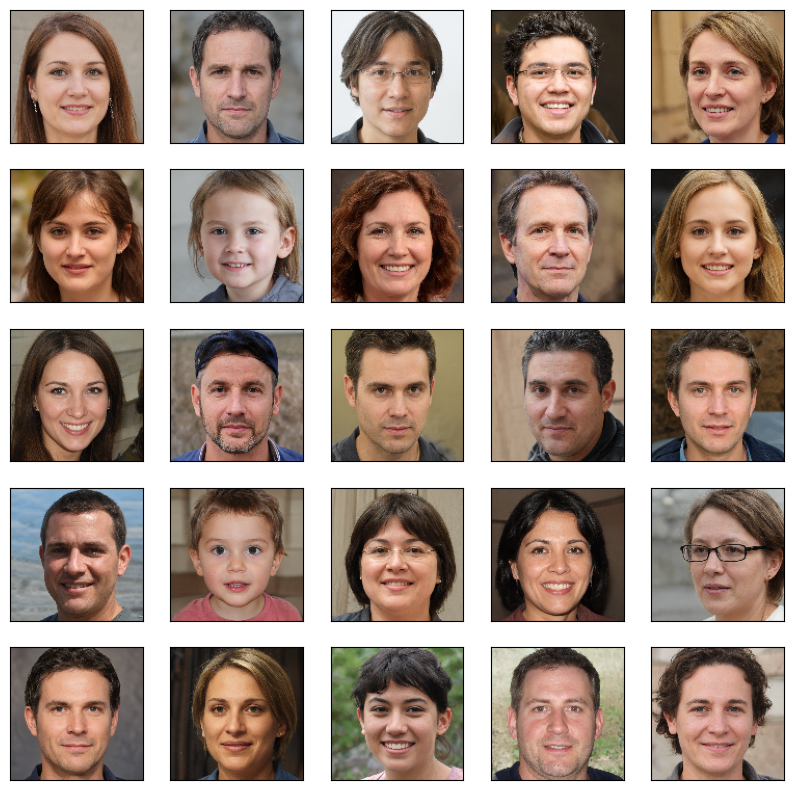

In [3]:
# visualize our image

def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
#     plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])
        
plot_images(5)

In [4]:
# define batch size

BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(
    np.array(_img)
).batch(BATCH_SIZE)

# Build Generator and Discriminator

In [5]:
# import tensorflow API

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Reshape,
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    Conv2DTranspose,
)

In [6]:
# generator

latent_dim = 100

def Generator():
    model = Sequential()
    model.add(Dense(128*128*3, use_bias=False, input_shape=(latent_dim, )))
    model.add(Reshape((128, 128, 3)))
    
    # downsampling
    model.add(Conv2D(128, 4, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False))
    model.add(Conv2D(128, 4, strides=2, padding="same", kernel_initializer="he_normal", use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, 4, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False))
    model.add(Conv2D(256, 4, strides=2, padding="same", kernel_initializer="he_normal", use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(512, 4, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False))
    model.add(Conv2D(512, 4, strides=2, padding="same", kernel_initializer="he_normal", use_bias=False))
    model.add(LeakyReLU())
    
    # upsampling
    model.add(Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(3, 4, strides = 1, padding = 'same',activation = 'tanh'))
    
    return model

In [7]:
def Discriminator():
    model = Sequential()
    model.add(Input((SIZE, SIZE, 3)))
    
    model.add(Conv2D(128, 4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(128, 4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, 4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, 4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(512, 4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(LeakyReLU())
    
    model.add(Flatten())
    model.add(Dense(1 ,activation = 'sigmoid'))
    return model

In [8]:
generator = Generator()
discriminator = Discriminator()

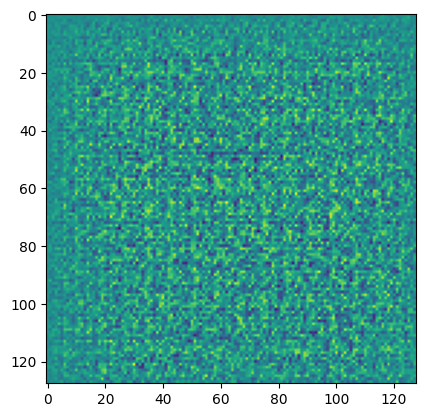

In [9]:
# plot image generated by generator

noise = np.random.normal(-1, 1, (1, 100))
img = generator(noise)
plt.imshow(img[0, :, :, 0])
plt.show()

In [10]:
# define loss and optimizer

optimizer = tf.keras.optimizers.legacy.RMSprop(
    learning_rate = 0.0001,
    clipvalue = 1.,
    decay = 1e-8
)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [12]:
def train_steps(images):
    noise = np.random.normal(0,1,(BATCH_SIZE,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [13]:
def plot_generated_images(square = 5, epochs = 0):
    
    
    plt.figure(figsize = (10,10))
    for i in range(square * square):
        if epochs != 0:    
            if(i == square //2):
                plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()

In [14]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [15]:
train(15,dataset)


Epoch : 1


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 Time:263.0
Generator Loss: 0.6216590404510498 Discriminator Loss: 1.5541993379592896

Epoch : 2
 Time:255.0
Generator Loss: 1.4476165771484375 Discriminator Loss: 0.5113925337791443

Epoch : 3
 Time:255.0
Generator Loss: 0.8333290219306946 Discriminator Loss: 1.2325689792633057

Epoch : 4
 Time:254.0
Generator Loss: 0.6166489124298096 Discriminator Loss: 1.102943778038025

Epoch : 5
 Time:255.0
Generator Loss: 0.4654155969619751 Discriminator Loss: 1.381792664527893

Epoch : 6
 Time:255.0
Generator Loss: 0.7560269832611084 Discriminator Loss: 1.0717508792877197

Epoch : 7
 Time:254.0
Generator Loss: 1.1222639083862305 Discriminator Loss: 0.9524407386779785

Epoch : 8
 Time:255.0
Generator Loss: 0.49890488386154175 Discriminator Loss: 1.2207697629928589

Epoch : 9
 Time:254.0
Generator Loss: 1.1084963083267212 Discriminator Loss: 0.7851780652999878

Epoch : 10
 Time:255.0
Generator Loss: 0.7672793865203857 Discriminator Loss: 0.8019745349884033

Epoch : 11
 Time:255.0
Generator Loss: 0

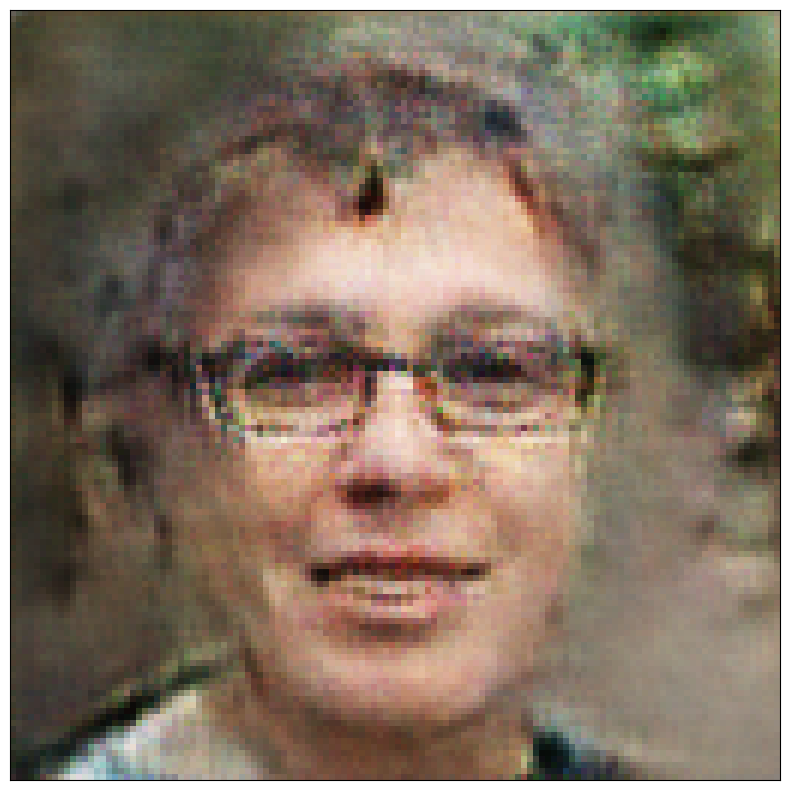

In [16]:
plot_generated_images(1)

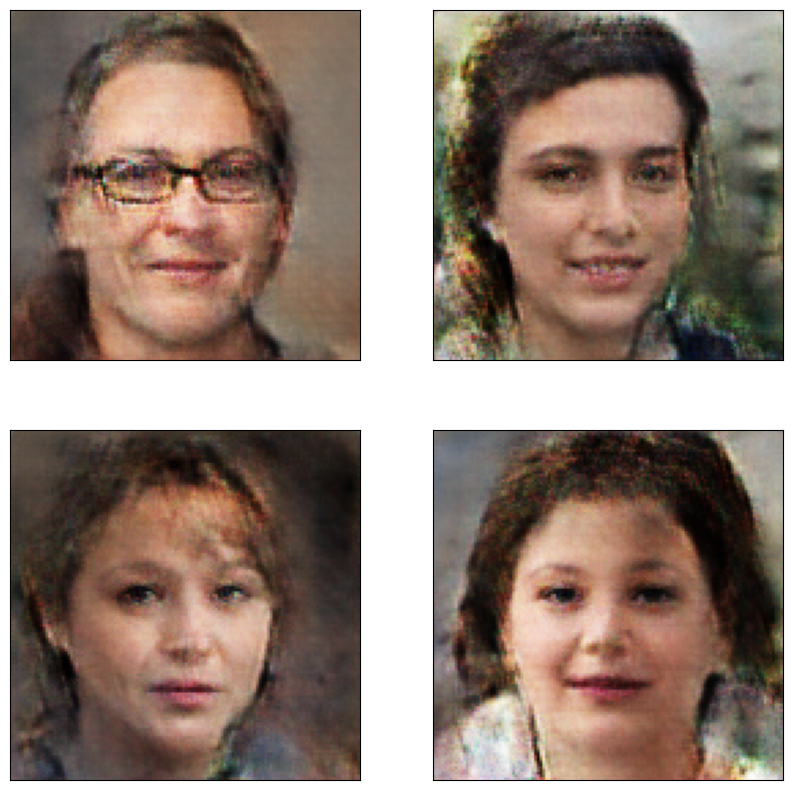

In [17]:
plot_generated_images(2)

In [18]:
# save generator and discriminator

generator.save('generator.keras')
discriminator.save("discriminator.keras")